In [59]:
import cv2
import numpy as np
import re
import easyocr
import pytesseract
import matplotlib.pyplot as plt
import os

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

print("Libraries loaded")


Libraries loaded


In [83]:
image_path = r"C:\Users\Prashanth S\Downloads\CR_Pipeline_Assignment\images\page_35.jpg"

img = cv2.imread(image_path)

if img is None:
    raise ValueError("Image not found")

In [84]:
def deskew_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    coords = np.column_stack(np.where(gray < 200))

    if len(coords) < 100:
        return image

    angle = cv2.minAreaRect(coords)[-1]

    if angle < -45:
        angle = 90 + angle

    if abs(angle) > 15:
        return image

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    return cv2.warpAffine(image, M, (w, h),
                          flags=cv2.INTER_CUBIC,
                          borderMode=cv2.BORDER_REPLICATE)


In [85]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    denoised = cv2.fastNlMeansDenoising(gray, h=30)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)

    resized = cv2.resize(enhanced, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)

    return resized


In [86]:
def extract_pii(text):
    pii = {}
    pii['phone_numbers'] = re.findall(r'\b\d{10,13}\b', text)
    pii['ages'] = re.findall(r'\bage[:\s]*\d{1,3}', text, re.IGNORECASE)
    pii['ids'] = re.findall(r'\b(?:ipd|uhid|id|pid)[:\s]*\d+\b', text, re.IGNORECASE)
    '''name_matches = re.findall(
        r'(?:patient name|name|mr\.?|mrs\.?|ms\.?)[:\s]*([a-zA-Z.\s]{3,40})',
        text,
        re.IGNORECASE
    )
    pii['names'] = [n.strip() for n in name_matches if len(n.strip()) > 2]
    '''
    name_matches = re.findall(
        r'(?:patient name|name|mr\.?|mrs\.?|ms\.?)[:\s]*([a-zA-Z][a-zA-Z.\s]{2,40})',
        text,
        re.IGNORECASE
    )

    pii['names'] = [n.strip() for n in name_matches if len(n.strip()) > 2]


    return pii


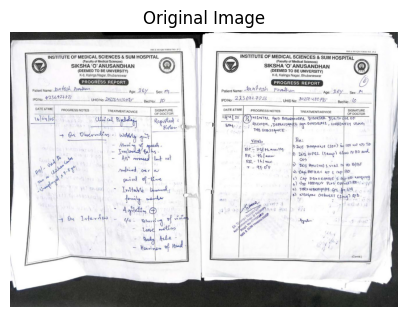

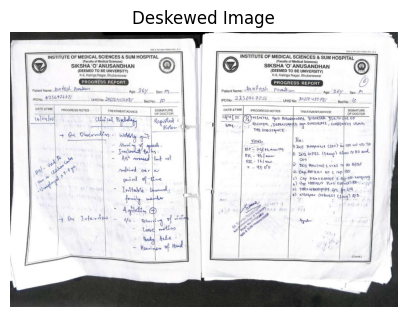

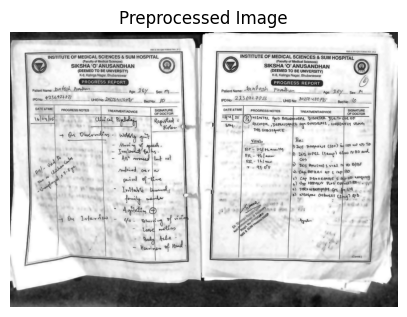

Using CPU. Note: This module is much faster with a GPU.



OCR OUTPUT: 

INSTITUTE OF MEDICAL SCIENCES & SUM HOSPITAL cx INSTITUTE OF gn comean, P SUM HOSPITAL
(Faculty of Medical Sciences) (i \ =
SIKSHA ‘O’ ANUSANDHAN "“Tnkieatenicennn (*)
(DEEMED TO BE UNIVERSITY) K-8, Kalinga Nagar, Bhu am
K-8, Kalinga Nagar, Bhubaneswar . banesw Z)
Patient Name: sontosh. Pepdden a ae BGY. Sex: M4 oc... Patient Name: Santosh P2adho- — ey. Sex: /.......
one: F23E92t FS? aH Ne APLSOMNOIATK Bed Noe... LO -cccsoossuee PDNo:. 2AS EFA FF UHID No: 2078 HO FAS Bed NolO cose:
’ } ‘ 1&4] 25 (R) MENTS. Awo BerAMoRAL PISORVER. PUeTo Use oF
\e lou las cl Ps ) Reprred . —_— ALCoH ot, DEPEND DANKE SYINDEENE , wwRRENTLY USING
0) Kev “ih 4 i THe suns: GOCE T
| = On Obnwvn - oat Roe
———— 4 Noh nd 100 wel 0% TID
| - aa f eed, . Troy THIQniye (20°)
| 4: af BP — USf Haw 4 \ atbwo IV 8D amd
y Yorelw ta . \ PR - 4% | aun Wy wPe2 (lamp
ye ® ra : _ ao ay ay >» Toy Mrotuo) pvial WV w O[BF ;
y ye” $ : Noktseod Oe r | ay YD (ap BiFiLAc yp 1 Cap/BD
Qn
w + “ 6) Cap Pexoegnae 1 mHproP u

In [87]:
# Original Image
plt.figure(figsize=(5,5))
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Deskewed Image
deskewed = deskew_image(img)

plt.figure(figsize=(5,5))
plt.title("Deskewed Image")
plt.imshow(cv2.cvtColor(deskewed, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Preprocessed Image
processed = preprocess_image(deskewed)

plt.figure(figsize=(5,5))
plt.title("Preprocessed Image")
plt.imshow(processed, cmap='gray')
plt.axis("off")
plt.show()

# OCR
reader = easyocr.Reader(['en'], gpu=False)

tess_text = pytesseract.image_to_string(processed, config='--oem 3 --psm 6')
easy_results = reader.readtext(processed, detail=0)

easy_text = " ".join(easy_results)

# Combine both outputs
raw_text = (tess_text + " " + easy_text).strip()

print("\nOCR OUTPUT: \n")
print(raw_text[:1000])

print(f"\nTotal OCR characters extracted: {len(raw_text)}")

In [88]:
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

cleaned_text = clean_text(raw_text)

print("\nCLEANED OCR TEXT: \n")
print(cleaned_text[:1000])

pii_data = extract_pii(cleaned_text)

print("\nPII DETECTED: \n")
print(pii_data)



CLEANED OCR TEXT: 

INSTITUTE OF MEDICAL SCIENCES & SUM HOSPITAL cx INSTITUTE OF gn comean, P SUM HOSPITAL (Faculty of Medical Sciences) (i \ = SIKSHA ‘O’ ANUSANDHAN "“Tnkieatenicennn (*) (DEEMED TO BE UNIVERSITY) K-8, Kalinga Nagar, Bhu am K-8, Kalinga Nagar, Bhubaneswar . banesw Z) Patient Name: sontosh. Pepdden a ae BGY. Sex: M4 oc... Patient Name: Santosh P2adho- — ey. Sex: /....... one: F23E92t FS? aH Ne APLSOMNOIATK Bed Noe... LO -cccsoossuee PDNo:. 2AS EFA FF UHID No: 2078 HO FAS Bed NolO cose: ’ } ‘ 1&4] 25 (R) MENTS. Awo BerAMoRAL PISORVER. PUeTo Use oF \e lou las cl Ps ) Reprred . —_— ALCoH ot, DEPEND DANKE SYINDEENE , wwRRENTLY USING 0) Kev “ih 4 i THe suns: GOCE T | = On Obnwvn - oat Roe ———— 4 Noh nd 100 wel 0% TID | - aa f eed, . Troy THIQniye (20°) | 4: af BP — USf Haw 4 \ atbwo IV 8D amd y Yorelw ta . \ PR - 4% | aun Wy wPe2 (lamp ye ® ra : _ ao ay ay >» Toy Mrotuo) pvial WV w O[BF ; y ye” $ : Noktseod Oe r | ay YD (ap BiFiLAc yp 1 Cap/BD Qn w + “ 6) Cap Pexoegnae 1 mH

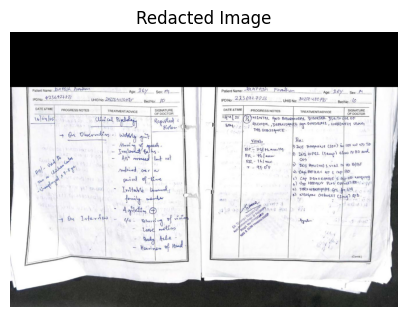

In [89]:
def redact_image(image, pii):
    redacted = image.copy()

    h, w, _ = redacted.shape

    # Black top section if any PII is detected
    if any(len(v) > 0 for v in pii.values()):
        cv2.rectangle(redacted, (0, 0), (w, int(h*0.2)), (0, 0, 0), -1)

    return redacted


redacted_img = redact_image(deskewed, pii_data)

plt.figure(figsize=(5,5))
plt.title("Redacted Image")
plt.imshow(cv2.cvtColor(redacted_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
